In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm, tqdm_notebook

In [2]:
import numba
from math import *
import random

In [3]:
x = np.arange(1, 101)

In [4]:
w = 30
p = 0.5 * np.exp(-(x-12)**2/w) + \
    0.8 * np.exp(-(x-37)**2/w) + \
    1.0 * np.exp(-(x-65)**2/w) + \
    0.5 * np.exp(-(x-87)**2/w)
p = p / np.sum(p)

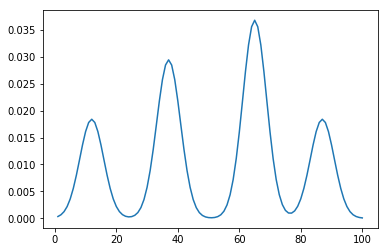

In [5]:
plt.plot(x, p)
plt.show()

In [6]:
@numba.jit('f8(f8)', nopython=True)
def potential(x):
    w = 30
    p = 0.5 * exp(-(x-12)**2/w) + \
        0.8 * exp(-(x-37)**2/w) + \
        1.0 * exp(-(x-65)**2/w) + \
        0.5 * exp(-(x-87)**2/w)
    return -log(p)

@numba.jit('f8(f8, f8, f8, f8)', nopython=True)
def new_position(pos, stepsize, min, max):
    direction = 1 if (random.random() > 0.5) else -1
    new_pos = pos + (random.random()*stepsize) * direction
    if new_pos < min or new_pos > max:
        return new_position(pos, stepsize, min, max)
    else:
        return new_pos

@numba.jit('f8[:](f8, i8, i8, f8, f8, f8)', nopython=True)
def run_mc(pos, step, interval, stepsize, min, max):
    pot = potential(pos)
    traj = []
    for i in range(step):
        new_pos = new_position(pos, stepsize, min, max)
        new_pot = potential(new_pos)
        diff = new_pot - pot
        crit = True if diff < 0 or exp(-diff/0.6) > random.random() else False
        if crit:
            pos = new_pos
            pot = new_pot
        if i % interval == 0:
            traj.append(pos)
    return np.array(traj)

class simulation():
    def __init__(self):
        self.traj = []
        self.stepsize = 0.5
        self.boundary = [0, 100]
        self.set_position(0)
        self.interval = 10
    
    def set_position(self, x):
        self.pos = x
        self.pot = potential(x)
        
    def run_mc(self, step):
        traj = run_mc(self.pos, step, self.interval, self.stepsize, self.boundary[0], self.boundary[1])
        self.traj = traj
        self.pos = traj[-1]
        self.pot = potential(self.pos)

In [11]:
from glob import glob
from scipy.stats import entropy
from msmbuilder.cluster import RegularSpatial
from msmbuilder.msm import MarkovStateModel

def collect(base, n_cycle):
    trajs = []
    for i in range(n_cycle):
        n_rep = len(glob(f'{base}/{i}_*.npy'))
        for j in range(n_rep):
            fn = f'{base}/{i}_{j}.npy'
            trajs.append(np.load(fn)[np.newaxis, :].T)
    return trajs

def model(trajs):
    cluster = RegularSpatial(d_min=1)
    cluster.cluster_centers_ = np.array([[c] for c in np.arange(0, 101, 0.5)])
    dtrajs = cluster.transform(trajs)
    lagtime = len(dtrajs[0]) // 2
    try:
        msm = MarkovStateModel(lag_time=lagtime, n_timescales=10, verbose=False)
        msm.fit(dtrajs)
    except:
        msm = MarkovStateModel(lag_time=lagtime, n_timescales=10, verbose=False, reversible_type='transpose')
        msm.fit(dtrajs)
    return cluster, msm

In [12]:
pis = []
pis_ = []
kls = []
outputdir = 'output/greedy_4_1000_1000/'

for i in tqdm_notebook(range(1, 11)):
    begin = 0
    end = i * 100
    trajs = collect(outputdir, end)
    cluster, msm = model(trajs)
    
    # predicted pi
    x = cluster.cluster_centers_[:, 0]
    pi = np.zeros_like(x)
    for si, ix in enumerate(msm.state_labels_):
        pi[ix] = msm.populations_[si]
    
    y = np.array([potential(_) for _ in x])
    pi_ = np.exp(-y/0.6)
    kl = entropy(pi, pi_)
    
    pis.append(pi)
    pis_.append(pi_)
    kls.append(kl)

In [13]:
for i in range(10):
    y = -0.6*np.log(np.sum(pis[i][155:195])/np.sum(pis[i]))
    y_ = -0.6*np.log(np.sum(pi_[155:195])/np.sum(pi_))
    print(y - y_, kls[i])

inf 2.001388565438469
inf 1.9985670152448352
inf 1.9986845305624001
inf 1.9982945053531558
inf 1.9980118056435394
inf 1.99772626412316
inf 1.9975020675199244
inf 2.314124073867502
inf 2.308484442533572
inf 2.297664438853559


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


/Users/sunhwan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


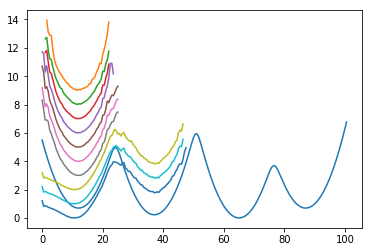

In [14]:
y = np.array([potential(_) for _ in x])
pi_ = np.exp(-y/0.6)
plt.plot(x, y)

for i in range(10):
    y = -0.6*np.log(pis[i])
    y -= np.min(y) - 9 + i
    plt.plot(x, y)
plt.show()